In [128]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re

In [215]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [216]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

train["LEN"] = train["POLYLINE"].apply(polyline_to_trip_duration)

In [217]:
train = train.sort_values('TIMESTAMP')

In [218]:
from datetime import datetime
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

train[["YR", "MON", "DAY", "HR", "WK"]] = train[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [219]:
train = train.drop(['TRIP_ID', 'DAY_TYPE', 'TIMESTAMP', 'ORIGIN_CALL'], axis=1)
train = train[train['LEN']!=0]
train['MISSING_DATA'] = train['MISSING_DATA'].replace({True:1, False:0})
train['CALL_TYPE'] = train['CALL_TYPE'].replace({'A':1, 'B':2, 'C':3})
train.loc[train['CALL_TYPE']==1, ['ORIGIN_STAND']] = 0
train.loc[train['CALL_TYPE']==3, ['ORIGIN_STAND']] = -1

In [220]:
train.dropna(inplace=True)

In [221]:
train['TAXI_ID'] = train['TAXI_ID'].apply(lambda x: int(str(x)[-4:]))

In [222]:
train.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
577,3,-1.0,380,0,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",360,2013,7,1,0,0
3,3,-1.0,520,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
0,3,-1.0,589,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
10,3,-1.0,233,0,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",315,2013,7,1,0,0
64,3,-1.0,360,0,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",630,2013,7,1,0,0


In [223]:
mean, std = train["LEN"].mean(), train["LEN"].std()
median = train["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=731.8313913107795 median=615.0 std=684.3600032077169


In [224]:
outlier_threshold = 3
df_trimmed = train[train["LEN"] < mean + outlier_threshold * std]

In [225]:
mean, std = df_trimmed["LEN"].mean(), df_trimmed["LEN"].std()
median = df_trimmed["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=686.8394802192312 median=615.0 std=397.85808320953936


In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [228]:
train = df_trimmed.drop(columns=['POLYLINE'])

In [229]:
s = StandardScaler()
X = s.fit_transform(train.drop(columns=['LEN']))
y = train['LEN']

In [230]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.5)

In [231]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)

In [232]:
X_train.shape

torch.Size([822693, 9])

In [233]:
model = nn.Sequential(
    nn.Linear(9, 27),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(27),
    nn.Linear(27, 9),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(9),
    nn.Linear(9, 1),
).to(device)

In [234]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [235]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [236]:
save = {'w':None,'history':[],'mse':np.inf}

In [237]:
n_epochs = 100   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [238]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [ ]:
for epoch in tqdm.tqdm(range(n_epochs)):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    for start in bar:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        a = y_pred.cpu().detach().numpy().transpose()[0]
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
    # evaluate accuracy at end of each epoch
    #scheduler.step()
    train_pred = model(X_train)
    history_train.append(float(loss_fn(train_pred, y_train)))
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history_test.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

 58%|█████▊    | 58/100 [08:18<05:58,  8.53s/it]

In [ ]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [194]:
test = pd.read_csv('test.csv')

In [195]:
tid =  test[['TRIP_ID']]

In [196]:
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [197]:
test = test.drop(['TRIP_ID', 'DAY_TYPE', 'TIMESTAMP', 'ORIGIN_CALL'], axis=1)
test['MISSING_DATA'] = test['MISSING_DATA'].replace({True:1, False:0})
test['CALL_TYPE'] = test['CALL_TYPE'].replace({'A':1, 'B':2, 'C':3})
test.loc[test['CALL_TYPE']==1, ['ORIGIN_STAND']] = 0
test.loc[test['CALL_TYPE']==3, ['ORIGIN_STAND']] = -1

In [198]:
test['TAXI_ID'] = test['TAXI_ID'].apply(lambda x: int(str(x)[-4:]))

In [199]:
test

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,MISSING_DATA,YR,MON,DAY,HR,WK
0,2,15.0,542,0,2014,8,14,17,3
1,2,57.0,108,0,2014,8,14,17,3
2,2,15.0,370,0,2014,8,14,17,3
3,2,53.0,492,0,2014,8,14,17,3
4,2,18.0,621,0,2014,8,14,17,3
...,...,...,...,...,...,...,...,...,...
315,1,0.0,430,0,2014,12,21,14,6
316,2,53.0,20,0,2014,12,21,14,6
317,3,-1.0,207,0,2014,12,21,14,6
318,1,0.0,667,0,2014,12,21,14,6


In [200]:
s = StandardScaler()
X = s.fit_transform(test)
test_input = torch.tensor(X, dtype=torch.float32).to(device)

In [201]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [202]:
torch.save(best_weights, 'weight.pt')

In [203]:
model.load_state_dict(torch.load('weight.pt'))

<All keys matched successfully>

In [204]:
pred = model(test_input).cpu().detach().numpy().transpose()[0]

In [205]:
pred[:10]

array([394.59113, 385.59485, 393.82538, 390.1651 , 394.48267, 440.08148,
       393.59802, 440.10446, 395.3473 , 393.6624 ], dtype=float32)

In [206]:
tid['TRAVEL_TIME'] = pred

In [207]:
tid

,TRIP_ID,TRAVEL_TIME
0,T1,394.591125
1,T2,385.594849
2,T3,393.825378
3,T4,390.165100
4,T5,394.482666
...,...,...
315,T323,434.756653
316,T324,395.893494
317,T325,394.424866
318,T326,434.756653


(array([ 4.,  4.,  9., 53., 12., 65., 56., 63., 35., 19.]),
 array([282.12207, 302.81473, 323.50742, 344.20007, 364.89273, 385.5854 ,
        406.27808, 426.97073, 447.6634 , 468.35608, 489.04874],
       dtype=float32),
 <BarContainer object of 10 artists>)

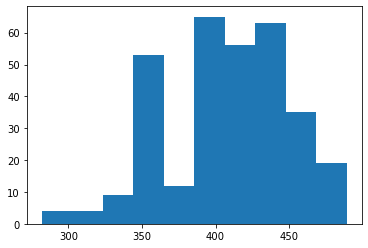

In [211]:
plt.hist(tid['TRAVEL_TIME'])

In [208]:
tid.to_csv('submission3.csv',index=False)

In [212]:
old_tid = pd.read_csv('sampSubmission3.csv')

(array([ 10.,  60.,  58., 115.,  31.,  22.,  16.,   5.,   1.,   2.]),
 array([ 499.83224 ,  557.743796,  615.655352,  673.566908,  731.478464,
         789.39002 ,  847.301576,  905.213132,  963.124688, 1021.036244,
        1078.9478  ]),
 <BarContainer object of 10 artists>)

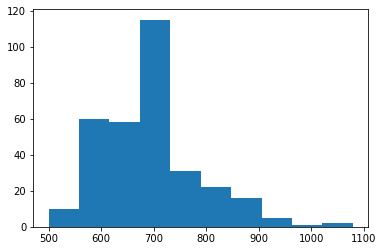

In [213]:
plt.hist(old_tid['TRAVEL_TIME'])